# Projet 5: Segmentez les clients d'un site e-commerce (analyse exploratoire)

Objectifs: 
- comprendre les différents **types d'utilisateurs** grâce à leur **comportement** et **données personnelles** => utilisation de méthodes **non supervisées** pour regrouper les clients de profils similaires
- créer une **segmentation des clients** que la société Olist pourra utiliser pour ses **campagnes de communication**. La segmentation proposée doit être exploitable et facile d’utilisation par l'équipe Marketing. Elle doit au minimum pouvoir différencier les **bons et moins bons clients en termes de commandes et de satisfaction**.
- fournir à l’équipe marketing une **description actionable de la segmentation et de sa logique sous-jacente** pour une utilisation optimale, ainsi qu’une proposition de **contrat de maintenance** basée sur une analyse de la **stabilité des segments au cours du temps**. Une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente doit être faite afin de pouvoir rédiger le devis de contrat de maintenance.

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation des données](#data)
3. [Consolidation des données (par order_id)](#conso)
4. [Consolidation des données (par customer_unique_id)](#tab_cli)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# Pour vérifier si la convention PEP8 est respectée
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import unidecode  # caractères spéciaux

import datetime as dt

from scipy.stats import chi2_contingency

# Configuration générale des graphiques
parameters = {'axes.labelsize': 13,
              'axes.titlesize': 16,
              'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
# pd.options.display.float_format = '{:20,.2f}'.format

## Chargement et visualisation des données <a class="anchor" id="data"></a>

Olist nous fournit une **base de données anonymisée** comportant des informations sur:

- l’historique de commandes, 
- les produits achetés, 
- les commentaires de satisfaction, 
- et la localisation des clients depuis janvier 2017

Seuls les 3% des clients qui ont réalisé plusieurs commandes nous intéressent.

A noter que le code fourni doit respecter la convention PEP8 pour être exploité par Olist. Quelques exemples de conventions à respecter:
- encodage UTF-8
- indentation de 4 caractères
- 79 caractères par ligne
- imports à déclarer au début du script

Nous allons dans cette partie charger les données de chaque dataset afin de comprendre quelles sont celles qui pourront nous être utiles pour identifier les différents types d'utilisateurs.

Nous vérifierons les également les lignes qui apparaissent plusieurs fois sur les clefs de jointures.

In [3]:
# Import des datasets
customers = pd.read_csv('data/olist_customers_dataset.csv',
                        sep=',',
                        encoding='utf-8')
customers.name = 'customers'

geo = pd.read_csv('data/olist_geolocation_dataset.csv',
                  sep=',',
                  encoding='utf-8')
geo.name = 'geo'

items = pd.read_csv('data/olist_order_items_dataset.csv',
                    sep=',',
                    encoding='utf-8')
items.name = 'items'

payments = pd.read_csv('data/olist_order_payments_dataset.csv',
                       sep=',',
                       encoding='utf-8')
payments.name = 'payments'

reviews = pd.read_csv('data/olist_order_reviews_dataset.csv',
                      sep=',',
                      encoding='utf-8')
reviews.name = 'reviews'

orders = pd.read_csv('data/olist_orders_dataset.csv',
                     sep=',',
                     encoding='utf-8')
orders.name = 'orders'

products = pd.read_csv('data/olist_products_dataset.csv',
                       sep=',',
                       encoding='utf-8')
products.name = 'products'

sellers = pd.read_csv('data/olist_sellers_dataset.csv',
                      sep=',',
                      encoding='utf-8')
sellers.name = 'sellers'

category = pd.read_csv('data/product_category_name_translation.csv',
                       sep=',',
                       encoding='utf-8')
category.name = 'category'

**Architecture des données**
<img src="data\Data_Scheme.PNG">

### olist_customers_dataset.csv

Ce jeu de données contient des informations sur le **client** et son **emplacement**. Il permet **d'identifier les clients uniques dans l'ensemble de données des commandes** et pour trouver le **lieu de livraison des commandes**.

Le même client aura des identifiants différents pour des commandes différentes. Le but d'avoir un customer_unique_id dans l'ensemble de données est de permettre **d'identifier les clients qui ont fait des réachats au magasin**.

In [4]:
# Visualisation des 5 premières lignes du dataset
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
def shape_total_nan(dataframe):
    '''Fonction qui retourne le nombre de lignes,
    de variables, le nombre total de valeurs manquantes et
    le pourcentage associé'''
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing
                            / (dataframe.shape[0] * dataframe.shape[1])
                            * 100,
                            2)

    print(f"Nombre de lignes: {dataframe.shape[0]}")
    print(f"Nombre de colonnes: {dataframe.shape[1]}")
    print(f"Nombre total de NaN du dataset: {missing}")
    print(f"% total de NaN du dataset: {missing_percent}%")

In [6]:
shape_total_nan(customers)

Nombre de lignes: 99441
Nombre de colonnes: 5
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [7]:
def describe_variables(data):
    ''' Fonction qui prend un dataframe en entrée, et retourne un
    récapitulatif qui contient le nom des variables, leur type, un
    exemple de modalité, le nombre total de lignes, le nombre et
    pourcentage de valeurs distinctes, le nombre et pourcentage de
    valeurs non manquantes et de valeurs manquantes (NaN) et les
    principales statistiques pour les variables numériques (moyenne,
    médiane, distribution, variance, écart type, minimum, quartiles et
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns=[
        'Variable name', 'Variable type', 'Example', 'Raws', 'Distinct',
        '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean',
        'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%',
        '75%', 'Max'
    ])

    # Pour chaque colonne du dataframe
    for col in data.columns:

        # Définition des variables
        # type de la variable (object, float, int...)
        var_type = data[col].dtypes
        # premier élément notNA
        example = data[data[col].notna()][col].iloc[0]
        # nombre total de lignes
        nb_raw = len(data[col])
        # nombre de valeurs non manquantes
        count = len(data[col]) - data[col].isna().sum()
        # % de valeurs non manquantes
        percent_count = round(data[col].notnull().mean(), 4)*100
        # nombre de modalités que peut prendre la variable
        distinct = data[col].nunique()
        # % de valeurs distinctes
        percent_distinct = round(data[col].nunique()/len(data[col]), 4)
        percent_distinct = percent_distinct * 100
        # nombre de valeurs manquantes
        missing = data[col].isna().sum()
        # % de valeurs manquantes
        percent_missing = round(data[col].isna().mean(), 4)*100

        # Pour les var de type 'int' ou 'float': on remplit toutes les col
        if var_type == 'int32' or var_type == 'int64' or var_type == 'float':
            df = pd.concat([df, pd.DataFrame([[col, var_type, example, nb_raw,
                                               distinct, percent_distinct,
                                               count,
                                               percent_count,
                                               missing,
                                               percent_missing,
                                               round(data[col].mean(), 2),
                                               round(data[col].median(), 2),
                                               round(data[col].skew(), 2),
                                               round(data[col].kurtosis(), 2),
                                               round(data[col].var(), 2),
                                               round(data[col].std(), 2),
                                               round(data[col].min(), 2),
                                               round(data[col].quantile(0.25),
                                                     2),
                                               round(data[col].quantile(0.75),
                                                     2),
                                               data[col].max()]],
                                             columns=['Variable name',
                                                      'Variable type',
                                                      'Example',
                                                      'Raws',
                                                      'Distinct',
                                                      '% distinct',
                                                      'Not NaN',
                                                      '% Not NaN',
                                                      'NaN',
                                                      '% NaN',
                                                      'Mean',
                                                      'Median',
                                                      'Skew',
                                                      'Kurtosis',
                                                      'Variance',
                                                      'Std',
                                                      'Min',
                                                      '25%',
                                                      '75%',
                                                      'Max'])])

            # Pour les variables d'un autre type: on ne remplit que
            # les variables de compte

        else:
            df = pd.concat([df, pd.DataFrame([[col, var_type, example,
                                               nb_raw, distinct,
                                               percent_distinct,
                                               count,
                                               percent_count, missing,
                                               percent_missing,
                                               '', '', '', '', '', '',
                                               '', '', '', '']],
                                             columns=['Variable name',
                                                      'Variable type',
                                                      'Example',
                                                      'Raws',
                                                      'Distinct',
                                                      '% distinct',
                                                      'Not NaN',
                                                      '% Not NaN',
                                                      'NaN',
                                                      '% NaN',
                                                      'Mean',
                                                      'Median',
                                                      'Skew',
                                                      'Kurtosis',
                                                      'Variance',
                                                      'Std',
                                                      'Min',
                                                      '25%',
                                                      '75%',
                                                      'Max'])])

    return df.reset_index(drop=True)

In [8]:
describe_variables(customers)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,customer_id,object,06b8999e2fba1a1fbc88172c00ba8bc7,99441,99441,100.0,99441,100.0,0,0.0,,,,,,,,,,
1,customer_unique_id,object,861eff4711a542e4b93843c6dd7febb0,99441,96096,96.64,99441,100.0,0,0.0,,,,,,,,,,
2,customer_zip_code_prefix,int64,14409,99441,14994,15.08,99441,100.0,0,0.0,35137.47,24416.0,0.78,-0.79,887917168.42,29797.94,1003,11347.0,58900.0,99990
3,customer_city,object,franca,99441,4119,4.14,99441,100.0,0,0.0,,,,,,,,,,
4,customer_state,object,SP,99441,27,0.03,99441,100.0,0,0.0,,,,,,,,,,


In [9]:
# Nombre de doublons totaux
print(f"Lignes en doublons: {customers.duplicated().sum()}")

Lignes en doublons: 0


In [10]:
# Nombre de commandes par customer_unique_id
customers_orders = customers["customer_unique_id"].value_counts()

print("Nb de commandes par client (> 2 commandes)")
customers_orders[customers_orders > 1]

Nb de commandes par client (> 2 commandes)


8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
370cd3b09ea745fe047fd11db7430441     2
d7c6bdf20c4ec9c9cda815dde58e778a     2
a366793a4999f8cc135855c4dd347421     2
156283b6ca35ef976a0265903145fd5e     2
d83257348027bd8c59a228cc034de5e3     2
Name: customer_unique_id, Length: 2997, dtype: int64

Observations:

- aucune valeur manquante
- la variable customer_id ne comporte que des éléments uniques
- certains customer_unique_id apparaissent sur plusieurs lignes du dataset correspondant à des commandes différentes
- ce dataset est relié au dataset geolocation par la clef zip_code_prefix et au dataset orders par la clef customer_id%

### olist_geolocation_dataset.csv

Ce jeu de données contient des informations sur les **codes postaux** brésiliens et leurs coordonnées **lat/lng**. Il permet de calculer la distance entre le vendeur et le client.

In [11]:
# Visualisation des 5 premières lignes du dataset
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [12]:
# Shape du dataset
shape_total_nan(geo)

Nombre de lignes: 1000163
Nombre de colonnes: 5
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [13]:
# Description des variables
describe_variables(geo)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,geolocation_zip_code_prefix,int64,1037,1000163,19015,1.9,1000163,100.0,0,0.0,36574.17,26530.0,0.69,-0.94,933261912.34,30549.34,1001,11075.0,63504.0,99990
1,geolocation_lat,float64,-23.545621,1000163,717360,71.72,1000163,100.0,0,0.0,-21.18,-22.92,1.57,2.85,32.67,5.72,-36.61,-23.6,-19.98,45.065933
2,geolocation_lng,float64,-46.639292,1000163,717613,71.75,1000163,100.0,0,0.0,-46.39,-46.64,-0.1,4.73,18.23,4.27,-101.47,-48.57,-43.77,121.105394
3,geolocation_city,object,sao paulo,1000163,8011,0.8,1000163,100.0,0,0.0,,,,,,,,,,
4,geolocation_state,object,SP,1000163,27,0.0,1000163,100.0,0,0.0,,,,,,,,,,


In [14]:
# Doublons totaux
print(f"Lignes en doublons: {geo.duplicated().sum()}")

Lignes en doublons: 261831


In [15]:
# Suppression des doublons intégraux
geo = geo.drop_duplicates()
geo.shape

(738332, 5)

In [16]:
# Nombre de lignes ayant le même zip_code_prefix
print(f"Nb lignes: {geo.duplicated('geolocation_zip_code_prefix').sum()}")

# Récupération des zip_code_prefix qui apparaissent plusieurs fois
zip_code_dup = geo[geo.duplicated('geolocation_zip_code_prefix')][
    'geolocation_zip_code_prefix'].unique()

# Filtrage du dataset sur ces zip_code_prefix
geo_dup = geo[geo['geolocation_zip_code_prefix'].isin(
    zip_code_dup)].sort_values(
    by='geolocation_zip_code_prefix')
geo_dup

Nb lignes: 719317


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
851,1001,-23.549825,-46.633970,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
299,1001,-23.549698,-46.633909,sao paulo,SP
235,1001,-23.550642,-46.634410,sao paulo,SP
519,1001,-23.551337,-46.634027,sao paulo,SP
...,...,...,...,...,...
999808,99980,-28.387842,-51.846890,david canabarro,RS
999775,99980,-28.386689,-51.847091,david canabarro,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS
999864,99990,-28.329472,-51.769109,muliterno,RS


Un même zip_code prefix peut avoir différentes latitudes et longitudes. Afin d'avoir des zip_codes uniques, nous allons calculer la moyenne des latitudes et longitudes par code postal puis récupérer la ville et l'état:

In [17]:
# Moyenne des lat et lon par code postal
zip_mean = geo.groupby('geolocation_zip_code_prefix')[
    ['geolocation_lat', 'geolocation_lng']].mean()

# On conserve une ville par code postal
zip_city = geo[['geolocation_zip_code_prefix',
                'geolocation_city',
                'geolocation_state']].groupby(
    ['geolocation_zip_code_prefix',
     'geolocation_city',
     'geolocation_state']).count().reset_index()

zip_city = zip_city.drop_duplicates('geolocation_zip_code_prefix',
                                    keep='first')

# Merge
geo = pd.merge(left=zip_mean, right=zip_city,
               how='left', on='geolocation_zip_code_prefix')

Le dataset contenant 27 états distincts, nous allons réduire le nombre de modalités en les regroupant en zones.

In [18]:
# Modalités de geolocation_state
geo['geolocation_state'].unique()

array(['SP', 'AC', 'RJ', 'ES', 'MG', 'BA', 'SE', 'PE', 'RN', 'AL', 'PB',
       'CE', 'PI', 'MA', 'PA', 'AP', 'AM', 'RR', 'DF', 'GO', 'RO', 'TO',
       'MT', 'MS', 'PR', 'SC', 'RS'], dtype=object)

In [19]:
# Création du dictionnaire des zones
ZONES = {
    'PA': 'Nord',
    'AP': 'Nord',
    'RR': 'Nord',
    'SE': 'Nord_Est',
    'PE': 'Nord_Est',
    'RN': 'Nord_Est',
    'AL': 'Nord_Est',
    'PB': 'Nord_Est',
    'CE': 'Nord_Est',
    'PI': 'Nord_Est',
    'MA': 'Nord_Est',
    'AM': 'Nord_Ouest',
    'AC': 'Nord_Ouest',
    'DF': 'Centre',
    'GO': 'Centre',
    'TO': 'Centre',
    'MT': 'Centre',
    'BA': 'Centre_Est',
    'RO': 'Centre_Ouest',
    'PR': 'Sud',
    'SC': 'Sud',
    'RS': 'Sud',
    'SP': 'Sud_Est',
    'RJ': 'Sud_Est',
    'ES': 'Sud_Est',
    'MG': 'Sud_Est',
    'MS': 'Sud_Ouest',
}

In [20]:
def detect_words(values, dictionary):
    result = []
    for lib in values:
        categ = "AUTRE"
        for word, val in dictionary.items():
            if word in lib:
                categ = val
        result.append(categ)
    return result


geo["zone"] = detect_words(geo["geolocation_state"], ZONES)

In [21]:
# Création de tuples lat / lon
geo['lat_lon'] = list(zip(geo['geolocation_lat'], geo['geolocation_lng']))

In [22]:
# geo['point'] = geo.apply(lambda row: Point(latitude=row['geolocation_lat'],
#                                           longitude=row['geolocation_lng']),
#                         axis=1)

In [23]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,zone,lat_lon
0,1001,-23.550227,-46.634039,sao paulo,SP,Sud_Est,"(-23.55022651431653, -46.63403856911852)"
1,1002,-23.547657,-46.634991,sao paulo,SP,Sud_Est,"(-23.547657125819924, -46.634990509252304)"
2,1003,-23.549000,-46.635582,sao paulo,SP,Sud_Est,"(-23.548999834572523, -46.6355816587524)"
3,1004,-23.549829,-46.634792,sao paulo,SP,Sud_Est,"(-23.54982914119189, -46.634792029508745)"
4,1005,-23.549547,-46.636406,sao paulo,SP,Sud_Est,"(-23.549547473955094, -46.63640612884047)"


Observations:

- aucune valeur manquante
- un grand nombre de lignes en doublons qui ont été supprimées
- d'après l'architecture des données, le zip_code_prefix est la clef qui fait le lien avec les datasets customers et sellers
- ce dataset est dorénavant composé d'une observation par code postal
- un colonne 'zone' avec moins de modalités et regroupant plusieurs states a été crééé

### olist_order_items_dataset.csv

Ce dataset inclut les informations sur éléments achetés de chaque commande.

In [24]:
# Visualisation des premières lignes du dataset
items.sort_values(by='product_id').head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
106927,f30149f4a8882a08895b6a242aa0d612,1,00066f42aeeb9f3007548bb9d3f33c38,5670f4db5b62c43d542e1b2d56b0cf7c,2018-05-24 18:58:59,101.65,18.59
108215,f5eda0ded77c1293b04c953138c8331d,1,00088930e925c41fd95ebfe695fd2655,7142540dd4c91e2237acb7e911c4eba2,2017-12-18 19:32:19,129.90,13.93
5273,0bf736fd0fd5169d60de3699fcbcf986,1,0009406fd7479715e4bef61dd91f2462,4a3ca9315b744ce9f8e9374361493884,2017-12-29 16:12:36,229.00,13.10
48878,6f0dfb5b5398b271cc6bbd9ee263530e,1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-07 22:15:19,58.90,19.60
25833,3aba44d8e554ab4bb8c09f6f78032ca8,1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-16 13:35:21,58.90,19.60
73160,a6c1ae4d48280b5b3c43231ac6afd701,1,000d9be29b5207b54e86aa1b1ac54872,8ae520247981aa06bc94abddf5f46d34,2018-04-09 10:09:40,199.00,19.27
82591,bb9552306cf6879fde49f4ba3bd94299,2,0011c512eb256aa0dbbb544d8dffcf6e,b4ffb71f0cb1b1c3d63fad021ecf93e1,2017-12-22 20:38:29,52.00,15.80
88768,c9a34c30282dc36d017bc912f8d8dc91,1,00126f27c813603687e6ce486d909d01,cd68562d3f44870c08922d380acae552,2017-09-21 20:55:19,249.00,13.24
93674,d44be4540d1a35533a9f5c89377b77f1,1,00126f27c813603687e6ce486d909d01,cd68562d3f44870c08922d380acae552,2017-09-21 20:50:13,249.00,16.49
86374,c432657bb18ddf7f48b7227db09048d4,2,001795ec6f1b187d37335e1c4704762e,8b321bb669392f5163d04c59e235e066,2017-12-18 00:39:25,38.90,16.11


In [25]:
# Shape du dataset
shape_total_nan(items)

Nombre de lignes: 112650
Nombre de colonnes: 7
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [26]:
# Description des variables
describe_variables(items)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,order_id,object,00010242fe8c5a6d1ba2dd792cb16214,112650,98666,87.59,112650,100.0,0,0.0,,,,,,,,,,
1,order_item_id,int64,1,112650,21,0.02,112650,100.0,0,0.0,1.2,1.0,7.58,103.86,0.5,0.71,1,1.0,1.0,21
2,product_id,object,4244733e06e7ecb4970a6e2683c13e61,112650,32951,29.25,112650,100.0,0,0.0,,,,,,,,,,
3,seller_id,object,48436dade18ac8b2bce089ec2a041202,112650,3095,2.75,112650,100.0,0,0.0,,,,,,,,,,
4,shipping_limit_date,object,2017-09-19 09:45:35,112650,93318,82.84,112650,100.0,0,0.0,,,,,,,,,,
5,price,float64,58.9,112650,5968,5.3,112650,100.0,0,0.0,120.65,74.99,7.92,120.83,33721.42,183.63,0.85,39.9,134.9,6735.0
6,freight_value,float64,13.29,112650,6999,6.21,112650,100.0,0,0.0,19.99,16.26,5.64,59.79,249.84,15.81,0.0,13.08,21.15,409.68


In [27]:
# Doublons totaux
print(f"Lignes en doublons: {items.duplicated().sum()}")

Lignes en doublons: 0


In [28]:
# Nombre de lignes ayant le même order_id
print(f"Nb lignes: {items.duplicated(['order_id']).sum()}")

# Récupération des order_id qui apparaissent plusieurs fois
order_id_dup = items[items.duplicated('order_id')][
    'order_id'].unique()

# Filtrage du dataset sur ces order_id
items_dup = items[items['order_id'].isin(
    order_id_dup)].sort_values(
    by='order_id')
items_dup

Nb lignes: 13984


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
...,...,...,...,...,...,...,...
112634,fff8287bbae429a99bb7e8c21d151c41,1,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,180.00,48.14
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19


Un même order_id peut apparaitre plusieurs fois, c'est à dire à chaque fois qu'un article est rajouté dans la commande. Il ne s'agit pas de doublons.

Observations:

- aucune valeur manquante
- d'après l'architecture des données, le seller_id est la clef qui fait le lien avec le dataset sellers, order_id avec le dataset orders et product_id avec le dataset products
- il existe plusieurs lignes pour un même order_id, il s'agit des différents produits rajoutés dans la commande

Afin de pouvoir ensuite merger cette table avec celle des commandes tout en ayant une observation par commande, nous allons regrouper les lignes par order_id et créer les indicateurs qui nous intéressent:
- nombre d'articles achetés
- nombre d'articles différents achetés
- produit le plus acheté
- nombre de vendeurs
- vendeur préféré
- prix total des articles
- prix du transport
- prix de l'article le moins cher
- prix de l'article le plus cher

In [29]:
items_merge = items.groupby(['order_id'],
                            as_index=False,
                            dropna=False).agg(
    nb_art=('order_item_id', 'max'),
    nb_art_diff=('product_id', 'nunique'),
    art_pref=('product_id', lambda x: x.mode()[0]),
    nb_vendeurs=('seller_id', 'nunique'),
    vendeur_pref=('seller_id', lambda x: x.mode()[0]),
    prix_tot_art=('price', 'sum'),
    prix_transport=('freight_value', 'sum'),
    prix_art_min=('price', 'min'),
    prix_art_max=('price', 'max'))

In [30]:
# Vérification que la table contient bien une ligne par commande
items_merge.shape[0] == items['order_id'].nunique()

True

In [31]:
items_merge.head()

,order_id,nb_art,nb_art_diff,art_pref,nb_vendeurs,vendeur_pref,prix_tot_art,prix_transport,prix_art_min,prix_art_max
0,00010242fe8c5a6d1ba2dd792cb16214,1,1,4244733e06e7ecb4970a6e2683c13e61,1,48436dade18ac8b2bce089ec2a041202,58.90,13.29,58.90,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,1,e5f2d52b802189ee658865ca93d83a8f,1,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,239.90,239.90
2,000229ec398224ef6ca0657da4fc703e,1,1,c777355d18b72b67abbeef9df44fd0fd,1,5b51032eddd242adc84c38acab88f23d,199.00,17.87,199.00,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,1,7634da152a4610f1595efa32f14722fc,1,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,12.99,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1,ac6c3623068f30de03045865e4e10089,1,df560393f3a51e74553ab94004ba5c87,199.90,18.14,199.90,199.90


### olist_order_payments_dataset.csv

Ce dataset contient les informations sur les options de paiement.

In [32]:
# Visualisation des 5 premières lignes du dataset
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [33]:
# Shape du dataset
shape_total_nan(payments)

Nombre de lignes: 103886
Nombre de colonnes: 5
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [34]:
# Description des variables
describe_variables(payments)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,order_id,object,b81ef226f3fe1789b1e8b2acac839d17,103886,99440,95.72,103886,100.0,0,0.0,,,,,,,,,,
1,payment_sequential,int64,1,103886,29,0.03,103886,100.0,0,0.0,1.09,1.0,16.18,370.59,0.5,0.71,1,1.0,1.0,29
2,payment_type,object,credit_card,103886,5,0.0,103886,100.0,0,0.0,,,,,,,,,,
3,payment_installments,int64,8,103886,24,0.02,103886,100.0,0,0.0,2.85,1.0,1.66,2.55,7.22,2.69,0,1.0,4.0,24
4,payment_value,float64,99.33,103886,29077,27.99,103886,100.0,0,0.0,154.1,100.0,9.25,241.83,47303.67,217.49,0.0,56.79,171.84,13664.08


In [35]:
# Doublons totaux
print(f"Lignes en doublons: {payments.duplicated().sum()}")

Lignes en doublons: 0


In [36]:
# Nombre de lignes ayant le même order_id
print(f"Nb lignes: {payments.duplicated(['order_id']).sum()}")

# Récupération des order_id qui apparaissent plusieurs fois
order_id_dup = payments[payments.duplicated('order_id')][
    'order_id'].unique()

# Filtrage du dataset sur ces order_id
payments_dup = payments[payments['order_id'].isin(
    order_id_dup)].sort_values(
    by='order_id')
payments_dup

Nb lignes: 4446


,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
...,...,...,...,...,...
21648,ffa1dd97810de91a03abd7bd76d2fed1,2,voucher,1,418.73
32912,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13
3009,ffa39020fe7c8a3e907320e1bec4b985,2,voucher,1,64.01
75188,ffc730a0615d28ec19f9cad02cb41442,1,credit_card,1,14.76


Une même commande peut apparaitre sur plusieurs lignes. C'est le cas lorsque le client a payé avec 2 méthodes différentes. La variable payment_installments correspond au nombre de versements effectués par type de paiment. Il ne s'agit donc pas de doublons.

Observations:

- aucune valeur manquante
- d'après l'architecture des données, l'order_id est la clef qui fait le lien avec le dataset orders
- order_id apparait sur plusieurs lignes lorsque le client a utilisé différents moyens de paiment

Afin de pouvoir ensuite merger cette table avec celle des commandes tout en ayant une observation par commande, nous allons regrouper les lignes par order_id et créer les indicateurs qui nous intéressent:
- nombre maximum de facilités de paiement par commande
- moyen de paiement préféré

In [37]:
payments_pivot = payments.pivot(index=['order_id',
                                       'payment_sequential',
                                       'payment_installments'],
                                columns='payment_type',
                                values='payment_value').reset_index()

In [38]:
payments_merge = payments_pivot.groupby(['order_id'],
                                        as_index=False,
                                        dropna=False).agg(
    facil_paiement_max=('payment_installments', 'max'),
    boleto=('boleto', 'sum'),
    credit_card=('credit_card', 'sum'),
    debit_card=('debit_card', 'sum'),
    not_defined=('not_defined', 'sum'),
    voucher=('voucher', 'sum'))

payments_merge.head()

,order_id,facil_paiement_max,boleto,credit_card,debit_card,not_defined,voucher
0,00010242fe8c5a6d1ba2dd792cb16214,2,0.0,72.19,0.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,3,0.0,259.83,0.0,0.0,0.0
2,000229ec398224ef6ca0657da4fc703e,5,0.0,216.87,0.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,2,0.0,25.78,0.0,0.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,0.0,218.04,0.0,0.0,0.0


In [39]:
# Vérification que la table contient bien une ligne par commande
payments_merge.shape[0] == payments['order_id'].nunique()

True

In [40]:
payments_merge['moy_paiement_pref'] = payments_merge[['boleto',
                                                      'credit_card',
                                                      'debit_card',
                                                      'not_defined',
                                                      'voucher']].idxmax(
    axis='columns')

In [41]:
payments_merge = payments_merge[['order_id', 'facil_paiement_max',
                                 'moy_paiement_pref']]
payments_merge.head()

,order_id,facil_paiement_max,moy_paiement_pref
0,00010242fe8c5a6d1ba2dd792cb16214,2,credit_card
1,00018f77f2f0320c557190d7a144bdd3,3,credit_card
2,000229ec398224ef6ca0657da4fc703e,5,credit_card
3,00024acbcdf0a6daa1e931b038114c75,2,credit_card
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,credit_card


### olist_order_reviews_dataset.csv

Ce dataset contient les informations sur les commentaires des clients.

Après qu'un client ait acheté un produit sur Olist Store, le vendeur est informé qu'il doit exécuter la commande. Une fois que le client a reçu le produit, ou que la date de livraison estimée est arrivée, le client reçoit une enquête de satisfaction par e-mail où il peut donner une note sur l'expérience d'achat et écrire quelques commentaires.

In [42]:
# Visualisation des 5 premières lignes du dataset
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53


In [43]:
# Shape du dataset
shape_total_nan(reviews)

Nombre de lignes: 99224
Nombre de colonnes: 7
Nombre total de NaN du dataset: 145903
% total de NaN du dataset: 21.01%


In [44]:
# Description des variables
describe_variables(reviews)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,review_id,object,7bc2406110b926393aa56f80a40eba40,99224,98410,99.18,99224,100.0,0,0.0,,,,,,,,,,
1,order_id,object,73fc7af87114b39712e6da79b0a377eb,99224,98673,99.44,99224,100.0,0,0.0,,,,,,,,,,
2,review_score,int64,4,99224,5,0.01,99224,100.0,0,0.0,4.09,5.0,-1.36,0.51,1.82,1.35,1,4.0,5.0,5
3,review_comment_title,object,recomendo,99224,4527,4.56,11568,11.66,87656,88.34,,,,,,,,,,
4,review_comment_message,object,Recebi bem antes do prazo estipulado.,99224,36159,36.44,40977,41.3,58247,58.7,,,,,,,,,,
5,review_creation_date,object,2018-01-18 00:00:00,99224,636,0.64,99224,100.0,0,0.0,,,,,,,,,,
6,review_answer_timestamp,object,2018-01-18 21:46:59,99224,98248,99.02,99224,100.0,0,0.0,,,,,,,,,,


In [45]:
# Doublons totaux
print(f"Lignes en doublons: {reviews.duplicated().sum()}")

Lignes en doublons: 0


In [46]:
# Doublons sur la clef order_id
print(f"Nb lignes: {reviews.duplicated('order_id').sum()}")

# Récupération des order_id qui apparaissent plusieurs fois
order_id_dup = reviews[reviews.duplicated('order_id')]['order_id'].unique()

# Filtrage du dataset sur ces order_id
reviews_dup = reviews[reviews['order_id'].isin(order_id_dup)].sort_values(
    by='order_id')
reviews_dup

Nb lignes: 551


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,"Estou acostumada a comprar produtos pelo baratheon. Super confiável, transparência, qualidade e agilidade. Super recomendo.",2017-08-25 00:00:00,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06
...,...,...,...,...,...,...,...
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18 00:00:00,2017-11-18 09:02:48
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16 00:00:00,2017-08-17 11:56:55
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anuncio.",2017-08-22 00:00:00,2017-08-25 11:40:22
92230,870d856a4873d3a67252b0c51d79b950,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20 00:00:00,2017-12-20 18:50:16


Une même clef de jointure order_id existe plusieurs fois dans le dataset. Nous allons essayer de comprendre et de trouver une stratégie pour traiter ces doublons.

Stratégie de traitement des order_id_dupliqués:
- Completion des variables review_comment_message et review_comment_title NaN lorsque l'information existe sur une autre ligne
- On garde la date du commentaire la plus récente (review_answer_timestamp) 

In [47]:
def mapping(dataframe, var_to_map, var_mapping):
    table_mapping = dataframe.groupby(
        [var_mapping, var_to_map])['review_id'].count().reset_index()
    table_mapping = table_mapping.sort_values(var_to_map,
                                              ascending=True)  # sur col txt
    table_mapping = table_mapping.drop_duplicates(subset=var_mapping,
                                                  # first car nan after
                                                  keep='first')

    # Merge du dataframe avec la table de mapping
    df = pd.merge(left=dataframe, right=table_mapping[[var_mapping,
                                                       var_to_map]],
                  how="left", on=var_mapping)

    # Lorsque la var_to_map est NaN, je complète avec la valeur du mapping
    df[f'{var_to_map}_x'] = np.where(df[f'{var_to_map}_x'].isnull(),
                                     df[f'{var_to_map}_y'],
                                     df[f'{var_to_map}_x'])

    # On supprime la variable issue de la jointure et on enlève le suffixe _x
    df.rename(columns={f'{var_to_map}_x': var_to_map}, inplace=True)
    df.drop(f'{var_to_map}_y', axis='columns', inplace=True)

    return df

In [48]:
# Completion des variables ayant le même order_id
reviews = mapping(reviews, 'review_comment_message', 'order_id')
reviews = mapping(reviews, 'review_comment_title', 'order_id')

In [49]:
# Suppression des order_id dupliqués en conservant celui
# qui a le commentaire le plus récent
reviews = reviews.sort_values(by='review_answer_timestamp',
                              ascending=False).drop_duplicates('order_id',
                                                               keep='first')

# Doublons sur la clef order_id
print(f"Lignes en doublons: {reviews.duplicated('order_id').sum()}")

Lignes en doublons: 0


Observations:

- valeurs manquantes sur les variables sur les titres et commentaires des questionnaires de satisfaction envoyés aux clients
- d'après l'architecture des données, l'order_id est la clef qui fait le lien avec le dataset orders
- doublons sur l'order_id retraités en completant les valeurs manquantes puis conservant la date de commentaire la plus récente

### olist_orders_dataset.csv

Dataset principal sur les commandes passées par les différents clients.

In [50]:
# Visualisation des 5 premières lignes du dataset
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [51]:
# Shape du dataset
shape_total_nan(orders)

Nombre de lignes: 99441
Nombre de colonnes: 8
Nombre total de NaN du dataset: 4908
% total de NaN du dataset: 0.62%


In [52]:
# Description des variables
describe_variables(orders)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,order_id,object,e481f51cbdc54678b7cc49136f2d6af7,99441,99441,100.0,99441,100.0,0,0.0,,,,,,,,,,
1,customer_id,object,9ef432eb6251297304e76186b10a928d,99441,99441,100.0,99441,100.0,0,0.0,,,,,,,,,,
2,order_status,object,delivered,99441,8,0.01,99441,100.0,0,0.0,,,,,,,,,,
3,order_purchase_timestamp,object,2017-10-02 10:56:33,99441,98875,99.43,99441,100.0,0,0.0,,,,,,,,,,
4,order_approved_at,object,2017-10-02 11:07:15,99441,90733,91.24,99281,99.84,160,0.16,,,,,,,,,,
5,order_delivered_carrier_date,object,2017-10-04 19:55:00,99441,81018,81.47,97658,98.21,1783,1.79,,,,,,,,,,
6,order_delivered_customer_date,object,2017-10-10 21:25:13,99441,95664,96.2,96476,97.02,2965,2.98,,,,,,,,,,
7,order_estimated_delivery_date,object,2017-10-18 00:00:00,99441,459,0.46,99441,100.0,0,0.0,,,,,,,,,,


In [53]:
# Doublons totaux
print(f"Lignes en doublons: {orders.duplicated().sum()}")

Lignes en doublons: 0


Observations:

- quelques valeurs manquantes sur les variables order_approved_at, order_delivered_carrier_date et order_delivered_customer_date ce qui semble cohérent. En effet, une commande peut ne pas avoir été validée ou livrée.
- d'après l'architecture des données, l'order_id est la clef qui fait le lien avec les datasets order_payments, order_reviews et order_items => pas de doublons
- customer_id est la clef qui fait le lien avec order_customer => pas de doublons

### olist_products_dataset.csv

Dataset rassemblant tous les produits vendus par Olist.

In [54]:
# Visualisation des 5 premières lignes du dataset
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [55]:
# Shape du dataset
shape_total_nan(products)

Nombre de lignes: 32951
Nombre de colonnes: 9
Nombre total de NaN du dataset: 2448
% total de NaN du dataset: 0.83%


In [56]:
# Description des variables
describe_variables(products)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,product_id,object,1e9e8ef04dbcff4541ed26657ea517e5,32951,32951,100.0,32951,100.0,0,0.0,,,,,,,,,,
1,product_category_name,object,perfumaria,32951,73,0.22,32341,98.15,610,1.85,,,,,,,,,,
2,product_name_lenght,float64,40.0,32951,66,0.2,32341,98.15,610,1.85,48.48,51.0,-0.9,0.19,104.98,10.25,5.0,42.0,57.0,76.0
3,product_description_lenght,float64,287.0,32951,2960,8.98,32341,98.15,610,1.85,771.5,595.0,1.96,4.83,403371.35,635.12,4.0,339.0,972.0,3992.0
4,product_photos_qty,float64,1.0,32951,19,0.06,32341,98.15,610,1.85,2.19,1.0,2.19,7.26,3.02,1.74,1.0,1.0,3.0,20.0
5,product_weight_g,float64,225.0,32951,2204,6.69,32949,99.99,2,0.01,2276.47,700.0,3.6,15.13,18335855.69,4282.04,0.0,300.0,1900.0,40425.0
6,product_length_cm,float64,16.0,32951,99,0.3,32949,99.99,2,0.01,30.82,25.0,1.75,3.51,286.1,16.91,7.0,18.0,38.0,105.0
7,product_height_cm,float64,10.0,32951,102,0.31,32949,99.99,2,0.01,16.94,13.0,2.14,6.68,185.98,13.64,2.0,8.0,21.0,105.0
8,product_width_cm,float64,14.0,32951,95,0.29,32949,99.99,2,0.01,23.2,20.0,1.67,4.07,145.9,12.08,6.0,15.0,30.0,118.0


In [57]:
# Doublons totaux
print(f"Lignes en doublons: {products.duplicated().sum()}")

Lignes en doublons: 0


Observations:

- quelques valeurs manquantes
- product_id est la clef qui fait le lien avec le dataset products => pas de doublons

Nous ne conservons pour le merge avec la table consolidée que les variables product_id et product_category_name:

In [58]:
products_merge = products[['product_id', 'product_category_name']]

### olist_sellers_dataset.csv

Informations sur les vendeurs.

In [59]:
# Visualisation des 5 premières lignes du dataset
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [60]:
# Shape du dataset
shape_total_nan(sellers)

Nombre de lignes: 3095
Nombre de colonnes: 4
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [61]:
# Description des variables
describe_variables(sellers)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,seller_id,object,3442f8959a84dea7ee197c632cb2df15,3095,3095,100.0,3095,100.0,0,0.0,,,,,,,,,,
1,seller_zip_code_prefix,int64,13023,3095,2246,72.57,3095,100.0,0,0.0,32291.06,14940.0,0.92,-0.86,1070170061.46,32713.45,1001,7093.5,64552.5,99730
2,seller_city,object,campinas,3095,611,19.74,3095,100.0,0,0.0,,,,,,,,,,
3,seller_state,object,SP,3095,23,0.74,3095,100.0,0,0.0,,,,,,,,,,


In [62]:
# Doublons totaux
dblon = sellers.duplicated(subset=['seller_id',
                                   'seller_zip_code_prefix']).sum()
print(f"Doublons: {dblon}")

Doublons: 0


Observations:

- aucune valeur manquante
- seller_id est la clef qui fait le lien avec le dataset order_items et zip_code_prefix avec le dataset geolocation

### product_category_name_translation.csv

Traduction des categories des produits en anglais.

In [63]:
# Visualisation des 5 premières lignes du dataset
category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [64]:
# Shape du dataset
shape_total_nan(category)

Nombre de lignes: 71
Nombre de colonnes: 2
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [65]:
# Description des variables
describe_variables(category)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,product_category_name,object,beleza_saude,71,71,100.0,71,100.0,0,0.0,,,,,,,,,,
1,product_category_name_english,object,health_beauty,71,71,100.0,71,100.0,0,0.0,,,,,,,,,,


In [66]:
# Doublons totaux
print(f"Lignes en doublons: {category.duplicated().sum()}")

Lignes en doublons: 0


In [67]:
# Différentes catégories en anglais
category['product_category_name_english'].unique()

array(['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table',
       'furniture_decor', 'sports_leisure', 'perfumery', 'housewares',
       'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery',
       'tablets_printing_image', 'toys', 'fixed_telephony',
       'garden_tools', 'fashion_bags_accessories', 'small_appliances',
       'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff',
       'luggage_accessories', 'air_conditioning',
       'construction_tools_construction',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop',
       'office_furniture', 'market_place', 'electronics',
       'home_appliances', 'party_supplies', 'home_confort',
       'costruction_tools_tools', 'agro_industry_and_commerce',
       'furniture_mattress_and_upholstery', 'books_technical',
       'home_construction', 'musical_instruments',
       'furniture_living_room', 'construction_tools_lights',
       'indust

Il existe 71 catégories que nous allons réaffecter dans de plus grandes catégories pour réduire les modalités.

In [68]:
# Création du dictionnaire des catégories générales
BIG_CAT = {
    'health_beauty': 'hygiene/beauty',
    'computers_accessories': 'electronics',
    'auto': 'auto',
    'bed_bath_table': 'house/decoration/furnitures',
    'furniture_decor': 'house/decoration/furnitures',
    'sports_leisure': 'books/culture/leisure',
    'perfumery': 'hygiene/beauty',
    'housewares': 'house/decoration/furnitures',
    'telephony':  'electronics',
    'watches_gifts': 'electronics',
    'food_drink': 'food',
    'baby': 'baby',
    'stationery': 'house/decoration/furnitures',
    'tablets_printing_image': 'electronics',
    'toys': 'toys',
    'fixed_telephony': 'electronics',
    'garden_tools': 'DoItYourself',
    'fashion_bags_accessories': 'fashion/luggage',
    'small_appliances': 'electronics',
    'consoles_games': 'electronics',
    'audio': 'multimedia',
    'fashion_shoes': 'fashion/luggage',
    'cool_stuff': 'other',
    'luggage_accessories': 'fashion/luggage',
    'air_conditioning': 'electronics',
    'construction_tools_construction': 'DoItYourself',
    'kitchen_dining_laundry_garden_furniture': 'house/decoration/furnitures',
    'costruction_tools_garden': 'DoItYourself',
    'fashion_male_clothing': 'fashion/luggage',
    'pet_shop': 'pets',
    'office_furniture': 'house/decoration/furnitures',
    'market_place': 'other',
    'electronics': 'electronics',
    'home_appliances': 'electronics',
    'party_supplies': 'house/decoration/furnitures',
    'home_confort': 'house/decoration/furnitures',
    'costruction_tools_tools': 'DoItYourself',
    'agro_industry_and_commerce': 'other',
    'furniture_mattress_and_upholstery': 'house/decoration/furnitures',
    'books_technical': 'books/culture/leisure',
    'home_construction': 'DoItYourself',
    'musical_instruments': 'music',
    'furniture_living_room': 'house/decoration/furnitures',
    'construction_tools_lights': 'DoItYourself',
    'industry_commerce_and_business': 'other',
    'food': 'food',
    'art': 'books/culture/leisure',
    'furniture_bedroom': 'house/decoration/furnitures',
    'books_general_interest': 'books/culture/leisure',
    'construction_tools_safety': 'DoItYourself',
    'fashion_underwear_beach': 'fashion/luggage',
    'fashion_sport': 'fashion/luggage',
    'signaling_and_security': 'other',
    'computers': 'electronics',
    'christmas_supplies': 'house/decoration/furnitures',
    'fashio_female_clothing': 'fashion/luggage',
    'home_appliances_2': 'electronics',
    'books_imported': 'books/culture/leisure',
    'drinks': 'food',
    'cine_photo': 'books/culture/leisure',
    'la_cuisine': 'books/culture/leisure',
    'music': 'music',
    'home_comfort_2': 'house/decoration/furnitures',
    'small_appliances_home_oven_and_coffee': 'electronics',
    'cds_dvds_musicals': 'multimedia',
    'dvds_blu_ray': 'multimedia',
    'flowers': 'house/decoration/furnitures',
    'arts_and_craftmanship': 'books/culture/leisure',
    'diapers_and_hygiene': 'hygiene/beauty',
    'fashion_childrens_clothes': 'fashion/luggage',
    'security_and_services': 'other'
}

In [69]:
category["Big_Categ"] = detect_words(category["product_category_name_english"],
                                     BIG_CAT)

In [70]:
category["Big_Categ"].unique()

array(['hygiene/beauty', 'electronics', 'auto',
       'house/decoration/furnitures', 'books/culture/leisure', 'food',
       'baby', 'toys', 'DoItYourself', 'fashion/luggage', 'multimedia',
       'other', 'pets', 'music'], dtype=object)

In [71]:
category.head()

,product_category_name,product_category_name_english,Big_Categ
0,beleza_saude,health_beauty,hygiene/beauty
1,informatica_acessorios,computers_accessories,electronics
2,automotivo,auto,auto
3,cama_mesa_banho,bed_bath_table,house/decoration/furnitures
4,moveis_decoracao,furniture_decor,house/decoration/furnitures


Observations:

- aucune valeur manquante
- une catégorie plus large avec moins de modalités a été crééé

## Consolidation des données (par order_id) <a class="anchor" id="conso"></a>

### Merge

Dans cette partie nous allons relier les différents datasets entre-eux en se basant sur le schéma des données. Nous nous assurons à chaque jointure qu'il y a bien une ligne par commande.

In [72]:
# Merge orders avec customers
df_conso = pd.merge(left=orders, right=customers[['customer_id',
                                                  'customer_unique_id',
                                                  'customer_zip_code_prefix']],
                    how='left', on='customer_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 10
Nombre total de NaN du dataset: 4908
% total de NaN du dataset: 0.49%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195


In [73]:
# Merge avec geo
df_conso = pd.merge(left=df_conso,
                    right=geo[['geolocation_zip_code_prefix',
                               'zone',
                               'geolocation_lat',
                               'geolocation_lng']],
                    how='left',
                    left_on='customer_zip_code_prefix',
                    right_on='geolocation_zip_code_prefix')

df_conso.drop(columns=['customer_zip_code_prefix',
                       'geolocation_zip_code_prefix'], inplace=True)

df_conso.rename(columns={'geolocation_lat': 'customer_lat',
                         'geolocation_lng': 'customer_lon',
                         'zone': 'customer_zone'}, inplace=True)

shape_total_nan(df_conso)

df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 12
Nombre total de NaN du dataset: 5742
% total de NaN du dataset: 0.48%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580


In [74]:
# Merge orders avec reviews
df_conso = pd.merge(left=df_conso, right=reviews, how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 18
Nombre total de NaN du dataset: 155307
% total de NaN du dataset: 8.68%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


In [75]:
# Merge avec payments
df_conso = pd.merge(left=df_conso, right=payments_merge,
                    how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 20
Nombre total de NaN du dataset: 155309
% total de NaN du dataset: 7.81%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,facil_paiement_max,moy_paiement_pref
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,voucher
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3.0,credit_card
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58,1.0,credit_card
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,1.0,credit_card


In [76]:
# Merge avec order_items
df_conso = pd.merge(left=df_conso, right=items_merge,
                    how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 29
Nombre total de NaN du dataset: 162284
% total de NaN du dataset: 5.63%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,facil_paiement_max,moy_paiement_pref,nb_art,nb_art_diff,art_pref,nb_vendeurs,vendeur_pref,prix_tot_art,prix_transport,prix_art_min,prix_art_max
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,29.99,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,1.0,595fac2a385ac33a80bd5114aec74eb8,1.0,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,118.70,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3.0,credit_card,1.0,1.0,aa4383b373c6aca5d8797843e5594415,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,159.90,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58,1.0,credit_card,1.0,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,1.0,66922902710d126a0e7d26b0e3805106,45.00,27.20,45.00,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,1.0,credit_card,1.0,1.0,65266b2da20d04dbe00c5c2d3bb7859e,1.0,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,19.90,19.90


In [77]:
# Merge avec products
products_merge.rename(columns={'product_id': 'art_pref'},
                      inplace=True)
df_conso = pd.merge(left=df_conso, right=products_merge,
                    how='left', on='art_pref')
df_conso.rename(columns={'product_category_name': 'cat_pref'},
                inplace=True)
shape_total_nan(df_conso)
df_conso.head()

C:\Users\milie\AppData\Local\Temp\ipykernel_7084\2863078995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products_merge.rename(columns={'product_id': 'art_pref'},


Nombre de lignes: 99441
Nombre de colonnes: 30
Nombre total de NaN du dataset: 164479
% total de NaN du dataset: 5.51%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,facil_paiement_max,moy_paiement_pref,nb_art,nb_art_diff,art_pref,nb_vendeurs,vendeur_pref,prix_tot_art,prix_transport,prix_art_min,prix_art_max,cat_pref
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,29.99,29.99,utilidades_domesticas
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,1.0,595fac2a385ac33a80bd5114aec74eb8,1.0,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,118.70,118.70,perfumaria
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3.0,credit_card,1.0,1.0,aa4383b373c6aca5d8797843e5594415,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,159.90,159.90,automotivo
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58,1.0,credit_card,1.0,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,1.0,66922902710d126a0e7d26b0e3805106,45.00,27.20,45.00,45.00,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,1.0,credit_card,1.0,1.0,65266b2da20d04dbe00c5c2d3bb7859e,1.0,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,19.90,19.90,papelaria


In [78]:
# Merge avec category_name
category.rename(columns={'product_category_name': 'cat_pref',
                         'product_category_name_english': 'cat_pref_en',
                         'Big_Categ': 'Big_Categ_pref'},
                inplace=True)
df_conso = pd.merge(left=df_conso, right=category, how='left',
                    on='cat_pref')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 32
Nombre total de NaN du dataset: 168913
% total de NaN du dataset: 5.31%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,facil_paiement_max,moy_paiement_pref,nb_art,nb_art_diff,art_pref,nb_vendeurs,vendeur_pref,prix_tot_art,prix_transport,prix_art_min,prix_art_max,cat_pref,cat_pref_en,Big_Categ_pref
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,29.99,29.99,utilidades_domesticas,housewares,house/decoration/furnitures
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,1.0,595fac2a385ac33a80bd5114aec74eb8,1.0,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,118.70,118.70,perfumaria,perfumery,hygiene/beauty
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3.0,credit_card,1.0,1.0,aa4383b373c6aca5d8797843e5594415,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,159.90,159.90,automotivo,auto,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58,1.0,credit_card,1.0,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,1.0,66922902710d126a0e7d26b0e3805106,45.00,27.20,45.00,45.00,pet_shop,pet_shop,pets
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,1.0,credit_card,1.0,1.0,65266b2da20d04dbe00c5c2d3bb7859e,1.0,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,19.90,19.90,papelaria,stationery,house/decoration/furnitures


In [79]:
# Merge avec sellers
sellers.rename(columns={'seller_id': 'vendeur_pref'},
               inplace=True)
df_conso = pd.merge(left=df_conso, right=sellers[['vendeur_pref',
                                                  'seller_zip_code_prefix']],
                    how='left', on='vendeur_pref')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 33
Nombre total de NaN du dataset: 169688
% total de NaN du dataset: 5.17%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,facil_paiement_max,moy_paiement_pref,nb_art,nb_art_diff,art_pref,nb_vendeurs,vendeur_pref,prix_tot_art,prix_transport,prix_art_min,prix_art_max,cat_pref,cat_pref_en,Big_Categ_pref,seller_zip_code_prefix
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,29.99,29.99,utilidades_domesticas,housewares,house/decoration/furnitures,9350.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,1.0,595fac2a385ac33a80bd5114aec74eb8,1.0,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,118.70,118.70,perfumaria,perfumery,hygiene/beauty,31570.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3.0,credit_card,1.0,1.0,aa4383b373c6aca5d8797843e5594415,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,159.90,159.90,automotivo,auto,auto,14840.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58,1.0,credit_card,1.0,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,1.0,66922902710d126a0e7d26b0e3805106,45.00,27.20,45.00,45.00,pet_shop,pet_shop,pets,31842.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,1.0,credit_card,1.0,1.0,65266b2da20d04dbe00c5c2d3bb7859e,1.0,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,19.90,19.90,papelaria,stationery,house/decoration/furnitures,8752.0


In [80]:
# Merge avec geo
df_conso = pd.merge(left=df_conso,
                    right=geo[['geolocation_zip_code_prefix',
                               'zone',
                               'geolocation_lat',
                               'geolocation_lng']],
                    how='left',
                    left_on='seller_zip_code_prefix',
                    right_on='geolocation_zip_code_prefix')

df_conso.drop(columns=['seller_zip_code_prefix',
                       'geolocation_zip_code_prefix'], inplace=True)

df_conso.rename(columns={'geolocation_lat': 'seller_lat',
                         'geolocation_lng': 'seller_lon',
                         'zone': 'seller_zone'}, inplace=True)

shape_total_nan(df_conso)

df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 35
Nombre total de NaN du dataset: 171895
% total de NaN du dataset: 4.94%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zone,customer_lat,customer_lon,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,facil_paiement_max,moy_paiement_pref,nb_art,nb_art_diff,art_pref,nb_vendeurs,vendeur_pref,prix_tot_art,prix_transport,prix_art_min,prix_art_max,cat_pref,cat_pref_en,Big_Categ_pref,seller_zone,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,Sud_Est,-23.577482,-46.587077,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,voucher,1.0,1.0,87285b34884572647811a353c7ac498a,1.0,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,29.99,29.99,utilidades_domesticas,housewares,house/decoration/furnitures,Sud_Est,-23.680862,-46.444311
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,Centre_Est,-12.186877,-44.540232,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,1.0,595fac2a385ac33a80bd5114aec74eb8,1.0,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,118.70,118.70,perfumaria,perfumery,hygiene/beauty,Sud_Est,-19.807885,-43.980818
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,Centre,-16.745150,-48.514783,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3.0,credit_card,1.0,1.0,aa4383b373c6aca5d8797843e5594415,1.0,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,159.90,159.90,automotivo,auto,auto,Sud_Est,-21.363473,-48.229588
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,Nord_Est,-5.774002,-35.270976,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58,1.0,credit_card,1.0,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,1.0,66922902710d126a0e7d26b0e3805106,45.00,27.20,45.00,45.00,pet_shop,pet_shop,pets,Sud_Est,-19.836871,-43.923241
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,Sud_Est,-23.676257,-46.514580,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51,1.0,credit_card,1.0,1.0,65266b2da20d04dbe00c5c2d3bb7859e,1.0,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,19.90,19.90,papelaria,stationery,house/decoration/furnitures,Sud_Est,-23.541525,-46.262148


In [81]:
# Vérification que la table contient bien une ligne par commande
df_conso.shape[0] == df_conso['order_id'].nunique()

True

### Création de nouveaux indicateurs

Nous allons créer dans ce dataset consolidé d'autres indicateurs qui nous paraissent importants:
- durée de la livraison en jours entre la date où le client a passé commande et la date réelle de livraison 
- différence en jours entre la date estimée de livraison et la date réelle de livraison
- temps en jours que met le client avant de rédiger un commentaire à partir du moment où il reçoit le lien
- si la commande a été livrée (on supprimera les commandes non encore livrées)
- distance entre le vendeur et le client

In [82]:
# Transformation des dates au format datetime
df_conso['order_purchase_timestamp'] = pd.to_datetime(
    df_conso['order_purchase_timestamp'])
df_conso['order_delivered_customer_date'] = pd.to_datetime(
    df_conso['order_delivered_customer_date'])
df_conso['order_estimated_delivery_date'] = pd.to_datetime(
    df_conso['order_estimated_delivery_date'])
df_conso['review_creation_date'] = pd.to_datetime(
    df_conso['review_creation_date'])
df_conso['review_answer_timestamp'] = pd.to_datetime(
    df_conso['review_answer_timestamp'])

In [83]:
# Création des indicateurs
df_conso['dur_livr_jrs'] = (df_conso[
    'order_delivered_customer_date'] - df_conso[
    'order_purchase_timestamp']).dt.days

df_conso['diff_estime_livr_jrs'] = (df_conso[
    'order_estimated_delivery_date'] - df_conso[
    'order_delivered_customer_date']).dt.days

df_conso['redac_com_jrs'] = (df_conso[
    'review_answer_timestamp'] - df_conso[
    'review_creation_date']).dt.days

In [84]:
# Commande livrée ou non
df_conso.loc[df_conso['dur_livr_jrs'].isna(), 'com_livree'] = 0
df_conso.loc[~df_conso['dur_livr_jrs'].isna(), 'com_livree'] = 1

In [85]:
# Suppression des commandes non livrées
com_non_livrees = df_conso[df_conso['com_livree'] == 0]['order_id'].nunique()
print(f"Commandes non livrées: {com_non_livrees}")
df_conso = df_conso[df_conso['com_livree'] == 1]

Commandes non livrées: 2965


In [86]:
# Fonction qui calcule la distance
def haversine_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haversine_formula = np.sin(
        newlat/2.0)**2 + np.cos(
        lat1) * np.cos(
        lat2) * np.sin(
        newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haversine_formula))
    km = 6367 * dist
    return km

In [87]:
# Calcul de la distance entre le client et le vendeur
df_conso['distance_km'] = haversine_distance(df_conso['seller_lon'],
                                             df_conso['seller_lat'],
                                             df_conso['customer_lon'],
                                             df_conso['customer_lat'])

In [88]:
# Suppression des colonnes non utilisées
df_conso.drop(columns=['order_status',
                       'order_approved_at',
                       'order_delivered_carrier_date',
                       'order_delivered_customer_date',
                       'order_estimated_delivery_date',
                       'customer_lat',
                       'customer_lon',
                       'review_id',
                       'review_comment_title',
                       'review_comment_message',
                       'review_creation_date',
                       'review_answer_timestamp',
                       'art_pref',
                       'vendeur_pref',
                       'cat_pref',
                       'seller_lat',
                       'seller_lon',
                       'com_livree'], inplace=True)

### Données manquantes

Le nombre de lignes avec données manquantes étant relativement faible, nous décidons de les supprimer au lieu de rajouter du bruit.

In [89]:
# Nombre et % de NaN

def NaN_nb_percent(df):
    '''Fonction qui retourne le taux de remplissage et
    le nombre de valeurs manquantes de chaque variable du dataset.'''

    var_dict = {}

    for c in df.columns:
        var_dict[c] = []
        var_dict[c].append(round((df[c].notna().sum()/df.shape[0])*100, 2))
        var_dict[c].append(df[c].isna().sum())

    return pd.DataFrame.from_dict(
        data=var_dict,
        orient='index',
        columns=['Tx de remplissage', 'Nb NaN']).sort_values(
        by='Nb NaN', ascending=False)

In [90]:
# Taux de remplissage des colonnes
nan = NaN_nb_percent(df_conso)
nan[nan['Nb NaN'] > 0]

,Tx de remplissage,Nb NaN
Big_Categ_pref,98.57,1381
cat_pref_en,98.57,1381
redac_com_jrs,99.33,646
review_score,99.33,646
distance_km,99.50,479
customer_zone,99.73,264
seller_zone,99.78,216
facil_paiement_max,100.00,1
moy_paiement_pref,100.00,1


In [91]:
# Suppression des lignes avec au moins un NaN
df_conso.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [92]:
df_conso.shape

(93985, 22)

In [93]:
# Suppression de variables
del geo_dup
del orders
del reviews
del items
del payments
del customers
del products
del items_dup
del geo
del customers_orders
del zip_city
del zip_mean
del payments_dup
del sellers
del reviews_dup
del order_id_dup

### Analyse univariée par commande

In [94]:
describe_variables(df_conso)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,order_id,object,e481f51cbdc54678b7cc49136f2d6af7,93985,93985,100.0,93985,100.0,0,0.0,,,,,,,,,,
1,customer_id,object,9ef432eb6251297304e76186b10a928d,93985,93985,100.0,93985,100.0,0,0.0,,,,,,,,,,
2,order_purchase_timestamp,datetime64[ns],2017-10-02 10:56:33,93985,93495,99.48,93985,100.0,0,0.0,,,,,,,,,,
3,customer_unique_id,object,7c396fd4830fd04220f754e42b4e5bff,93985,91004,96.83,93985,100.0,0,0.0,,,,,,,,,,
4,customer_zone,object,Sud_Est,93985,9,0.01,93985,100.0,0,0.0,,,,,,,,,,
5,review_score,float64,4.0,93985,5,0.01,93985,100.0,0,0.0,4.16,5.0,-1.49,0.97,1.65,1.28,1.0,4.0,5.0,5.0
6,facil_paiement_max,float64,1.0,93985,24,0.03,93985,100.0,0,0.0,2.93,2.0,1.6,2.4,7.37,2.71,0.0,1.0,4.0,24.0
7,moy_paiement_pref,object,voucher,93985,4,0.0,93985,100.0,0,0.0,,,,,,,,,,
8,nb_art,float64,1.0,93985,17,0.02,93985,100.0,0,0.0,1.14,1.0,7.32,105.28,0.29,0.54,1.0,1.0,1.0,21.0
9,nb_art_diff,float64,1.0,93985,8,0.01,93985,100.0,0,0.0,1.04,1.0,8.11,99.15,0.05,0.23,1.0,1.0,1.0,8.0


In [95]:
# Période analysée
print(df_conso['order_purchase_timestamp'].min())
print(df_conso['order_purchase_timestamp'].max())

2016-10-03 09:44:50
2018-08-29 15:00:37


La période s'étend du 3/10/2016 au 29/08/2018.

In [96]:
def univ_plots_hist(dataframe, liste_col_quanti, nb_lignes, nb_col, nb_bins):

    for i, c in enumerate(liste_col_quanti, 1):
        ax = fig.add_subplot(nb_lignes, nb_col, i)
        ax.hist(dataframe[c], bins=nb_bins, color='#b8b8d2')
        ax.set_title(c, fontsize=10)
        ax.title.set_fontweight('bold')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show

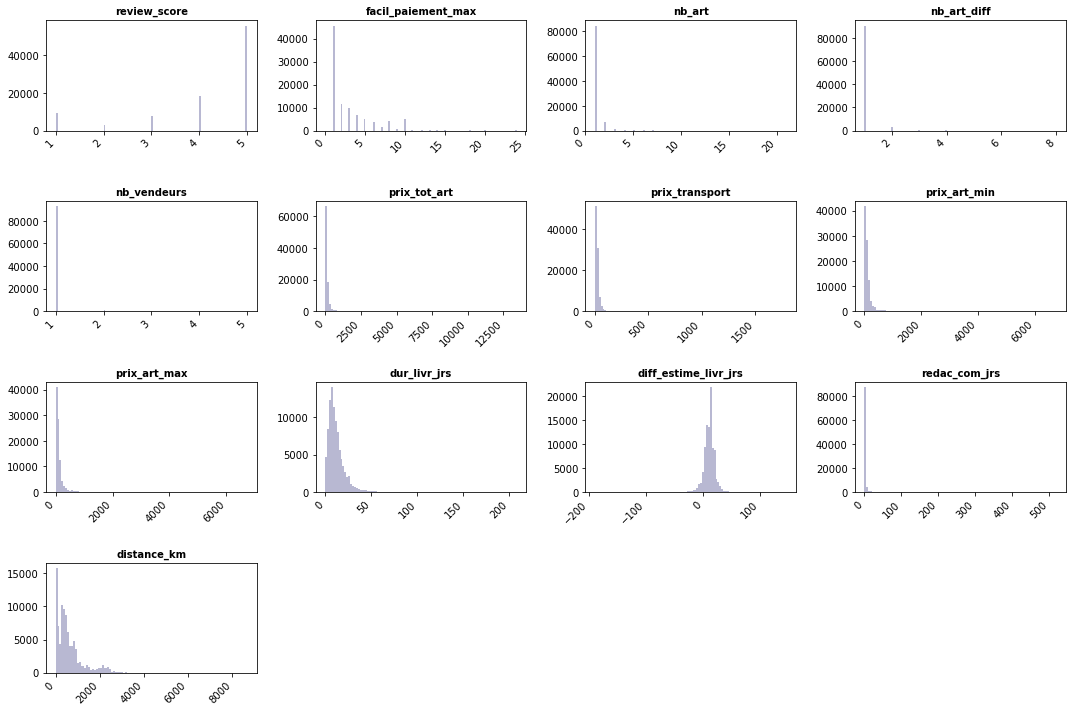

In [97]:
col_quanti = ['review_score', 'facil_paiement_max', 'nb_art', 'nb_art_diff',
              'nb_vendeurs', 'prix_tot_art',
              'prix_transport', 'prix_art_min', 'prix_art_max',
              'dur_livr_jrs', 'diff_estime_livr_jrs', 'redac_com_jrs',
              'distance_km']

fig = plt.figure(figsize=(15, 10))
univ_plots_hist(df_conso, col_quanti, 4, 4, 100)

In [98]:
def univariate_plots_box(dataframe, liste_col_quanti, nb_lignes, nb_col):
    for i, c in enumerate(liste_col_quanti, 1):
        ax = fig.add_subplot(nb_lignes, nb_col, i)
        ax = sns.boxplot(data=dataframe, x=c, showfliers=True,
                         color='#b8b8d2')
        ax.set_title(c)
        ax.title.set_fontweight('bold')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show

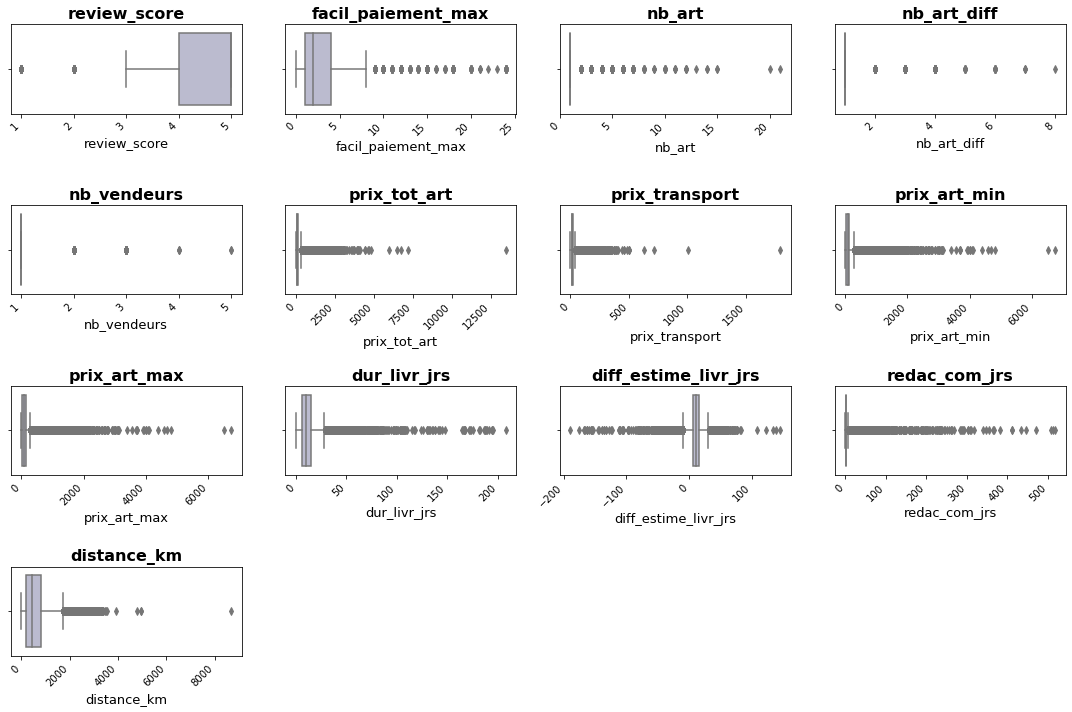

In [99]:
fig = plt.figure(figsize=(15, 10))
univariate_plots_box(df_conso, col_quanti, 4, 4)

In [100]:
def univariate_plots_quali(dataframe, liste_col_quali, nb_lignes, nb_col):
    for i, c in enumerate(liste_col_quali, 1):
        ax = fig.add_subplot(nb_lignes, nb_col, i)
        modalites = dataframe[c].value_counts()
        n_modalites = modalites.shape[0]

        if n_modalites > 15:
            modalites[0:15].plot.bar(color='#b8b8d2', edgecolor='black', ax=ax)

        else:
            modalites.plot.bar(color='#b8b8d2', edgecolor='black')

        ax.set_title(f'{c} ({n_modalites} modalités)',
                     fontweight='bold',
                     fontsize=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [lab[0:7] + '.' if len(lab) > 7
                        else lab for lab in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show

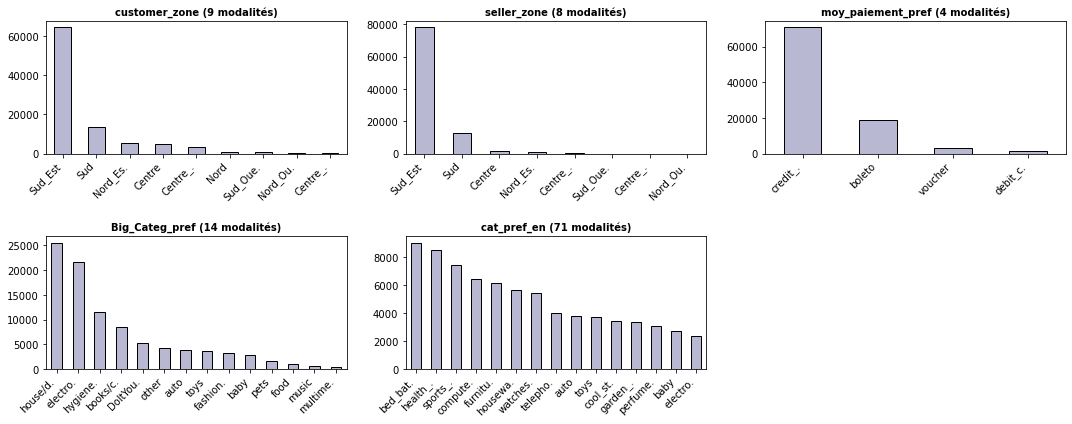

In [101]:
col_quali = ['customer_zone', 'seller_zone', 'moy_paiement_pref',
             'Big_Categ_pref', 'cat_pref_en']

fig = plt.figure(figsize=(15, 6))
univariate_plots_quali(df_conso, col_quali, 2, 3)

- Les clients notent plutôt favorablement lorsqu'ils passent une commande avec une majorité de 5/5
- Le montant des commandes est généralement peu élevé avec un montant moyen par commande de 137 Réals + 27 Réals de livraison
- Le nombre de facilités de paiement tourne autour de 3 en moyenne mais peuvent être beaucoup plus important
- La majorité des clients sélectionne un article par commande
- Il y a en général un vendeur unique par commande
- Il faut 12 jours en moyenne au client pour être livré
- Il y a en général 11 jours de retard dans les livraisons mais parfois le livreur est en avance
- Le client met 2 jours et demi en moyenne par commande pour rédiger un commentaire
- Les vendeurs se situent en moyenne à 600 km du client
- La majorité des commandes sont passées par des clients basés dans le Sud Est du Brésil
- La majorité des vendeurs se situe également dans le Sud Est
- Les clients paient majoritairement par carte de crédit
- Les produits les plus commandés sont les produits de maison/décoration/fournitures puis l'électronique

### Analyse bivariée / multivariée par commande

#### Variables quantitatives

Text(0.5, 1.0, 'Matrice de corrélation entre les variables quantitatives\n')

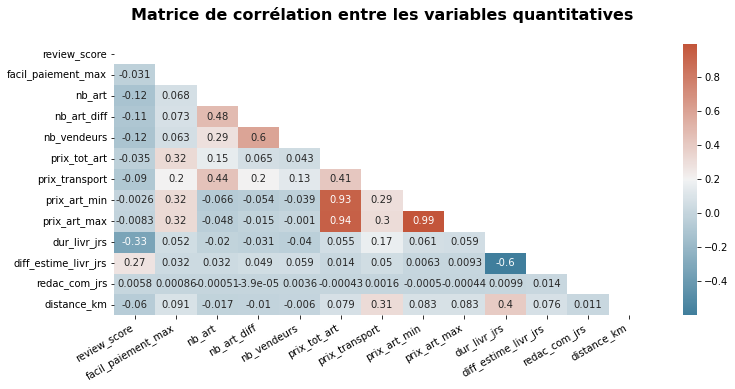

In [102]:
# Corrélation
corr = df_conso[col_quanti].corr()

# Création d'un masque
mask = np.triu(corr)

# Taille du graph
plt.subplots(figsize=(12, 5))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap avec masque
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap)
plt.xticks(rotation=30, ha='right')
plt.title("Matrice de corrélation entre les variables quantitatives\n",
          fontsize=16)

- La note attribuée à la commande est corrélée aux nombre de jours de retard de livraison et au nombre de jours de livraison
- Le montant total de la commande est corrélé au nombre de facilités de paiement
- Le montant du transport est lié au prix de l'article et à la distance entre le client et le vendeur

#### Une variable quantitative et une qualitative

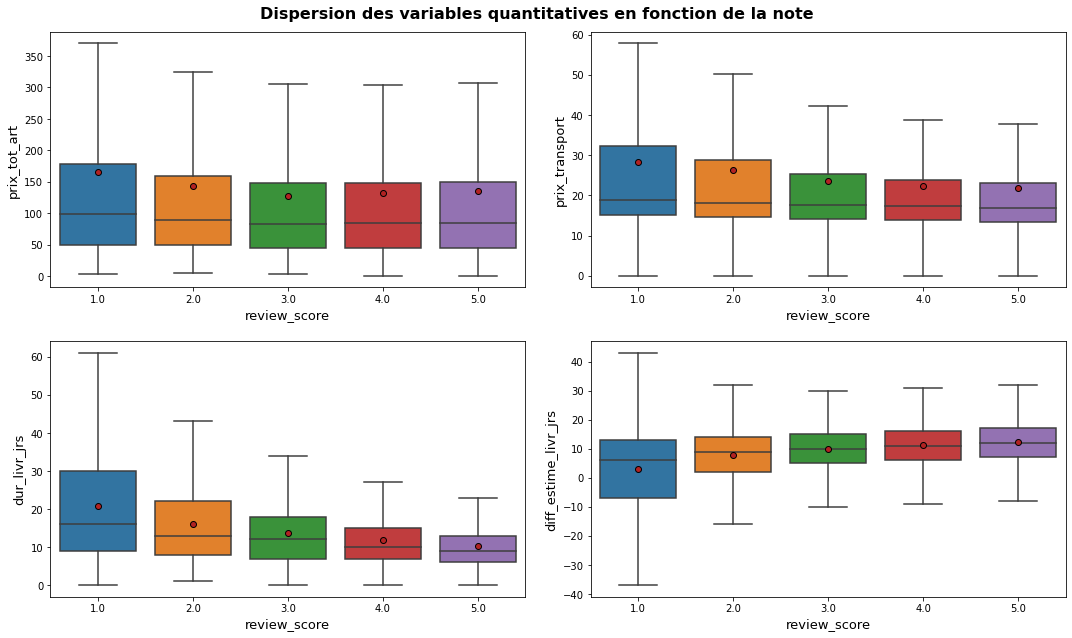

In [103]:
infl_note = ['prix_tot_art', 'prix_transport',
             'dur_livr_jrs', 'diff_estime_livr_jrs']

fig = plt.figure(figsize=(15, 9))

%pycodestyle_off
for i, c in enumerate(infl_note, 1):
    ax = fig.add_subplot(2, 2, i)
    meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
    ax = sns.boxplot(data = df_conso, y = c, x = 'review_score',
                     showfliers=False,
                     showmeans=True,
                     meanprops=meanprops)
    plt.suptitle('Dispersion des variables quantitatives en fonction de la note', fontsize=16,
             fontweight='bold')

    ax.title.set_fontweight('bold')
    
plt.tight_layout(w_pad=2, h_pad=2)
%pycodestyle_on

La note associée à la commande semble être surtout liée aux variables en rapport avec la livraison de la commande.
Les clients attribuent les meilleures notes lorsque le prix du transport est plus faible, les délais de livraison plus courts, et la date de livraison respectée ou en avance.

#### Variables qualitatives

In [104]:
def chi2_test(data, var_quali_1, var_quali_2,
              palette=sns.color_palette('pastel')):
    palette = palette
    # Table de contingence
    tab_cont = pd.crosstab(data[var_quali_1], data[var_quali_2])
    plt.figure(figsize=(12, 10))
    plt.title(f'Table de contingence {var_quali_1} / {var_quali_2}',
              fontsize=12, fontweight='bold')
    sns.heatmap(tab_cont, cmap="YlGnBu", annot=True, cbar=False, fmt="d")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    # Diagramme en barres selon les profils colonnes
    tab_cont_prop = pd.crosstab(data[var_quali_1], data[var_quali_2],
                                normalize="index")
    modalites = len(tab_cont.columns)
    if modalites <= 5:
        with sns.color_palette(palette):
            tab_cont_prop.plot(kind='bar', stacked=True,
                               figsize=(15, 9), width=0.8)
            plt.legend(loc="upper left", ncol=6)
            plt.xlabel(var_quali_1)
            plt.ylabel("Proportion")
            plt.xticks(rotation=45, ha='right')
            plt.title('Diagramme en barres selon les profils colonnes',
                      fontsize=12, fontweight='bold')
            plt.show()

        if len(np.where(tab_cont <= 5)[0]) == 0:
            print('Chaque effectif >= 5 => Test du Chi2 applicable')
            # Running Chi2 test
            print('----------------------------------------------------------')
            st_chi2, st_p, st_dof, st_exp = chi2_contingency(tab_cont)
            print(f"Chi2: {st_chi2}")
            print(f"Degrees of freedom: {st_dof}")
            print('----------------------------------------------------------')
            if st_p < 0.05:
                print(f"pvalue: {st_p} < 0.05 => var dépendantes")
            else:
                print(f"pvalue: {st_p} > 0.05 => var indépendantes")
        else:
            print("Au moins un effectif de la table de contingence < 5")
            print("Test du Chi2 d'indépendance")
            # Running Chi2 Independance
            print('----------------------------------------------------------')
            expected, observed, stat = pg.chi2_independence(data,
                                                            var_quali_1,
                                                            var_quali_2)
            print(stat)
            print('----------------------------------------------------------')
            if stat['pval'][0] < 0.05:
                print(f"pvalue: {stat['pval'][0]} < 0.05 = >var dépendantes")
            else:
                print(f"pvalue: {stat['pval'][0]} > 0.05 => var indépendantes")
    else:
        if len(np.where(tab_cont <= 5)[0]) == 0:
            print('Chaque effectif de la table de contingence >= 5')
            print('Test du Chi2 applicable')
            # Running Chi2 test
            print('----------------------------------------------------------')
            st_chi2, st_p, st_dof, st_exp = chi2_contingency(tab_cont)
            print(f"Chi2: {st_chi2}")
            print(f"Degrees of freedom: {st_dof}")
            print('----------------------------------------------------------')
            if st_p < 0.05:
                print(f"pvalue: {st_p} < 0.05 => var dépendantes")
            else:
                print(f"pvalue: {st_p} > 0.05 => var indépendantes")
        else:
            print("Au moins un effectif de la table de contingence < 5")
            print("Test du Chi2 d'indépendance")
            # Running Chi2 Independance
            print('----------------------------------------------------------')
            expected, observed, stat = pg.chi2_independence(data,
                                                            var_quali_1,
                                                            var_quali_2)
            print(stat)
            print('----------------------------------------------------------')
            if stat['pval'][0] < 0.05:
                print(f"pvalue: {stat['pval'][0]} < 0.05 => var dépendantes")
            else:
                print(f"pvalue: {stat['pval'][0]} > 0.05 => var indépendantes")

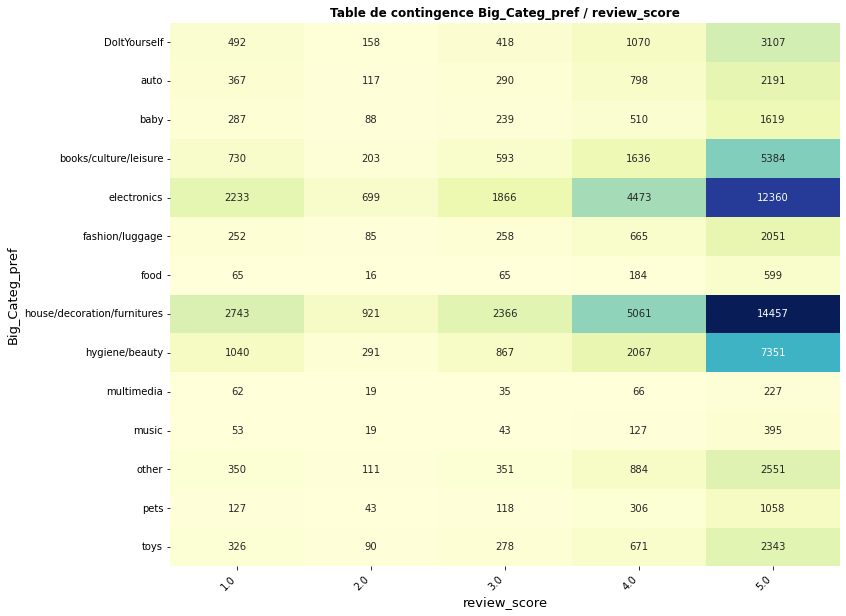

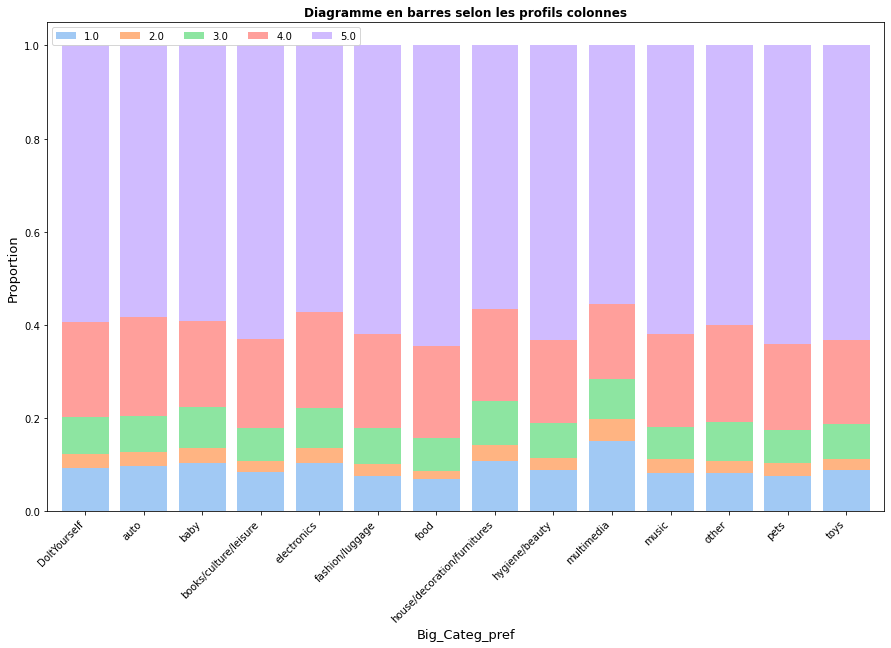

Chaque effectif >= 5 => Test du Chi2 applicable
----------------------------------------------------------
Chi2: 437.13550710573173
Degrees of freedom: 52
----------------------------------------------------------
pvalue: 2.6835146132938596e-62 < 0.05 => var dépendantes


In [105]:
chi2_test(df_conso, 'Big_Categ_pref', 'review_score')

Le test du Chi2 confirme l'hypothèse d'association entre les variables Big_Categ_pref et review_score.

Les meilleures notes semblent être attribuées aux aliments, musique, animaux et jouets et les moins bonnes aux catégories multimédia, maison/décoration, électronique etc.

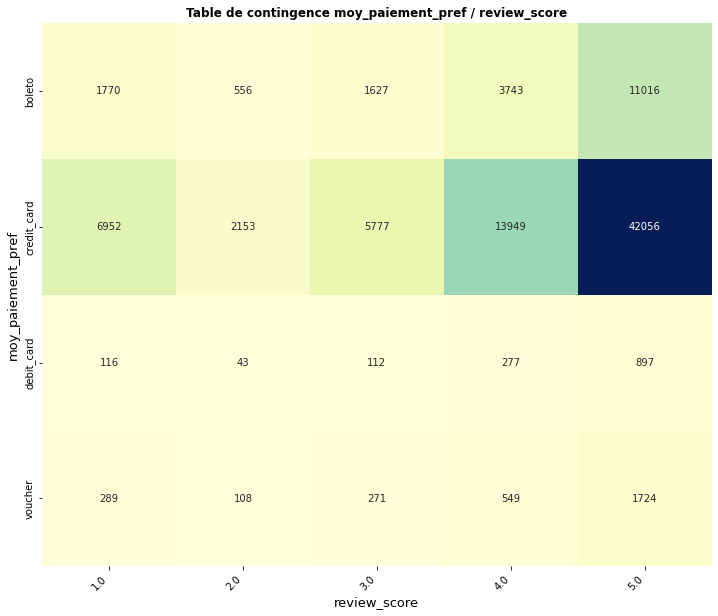

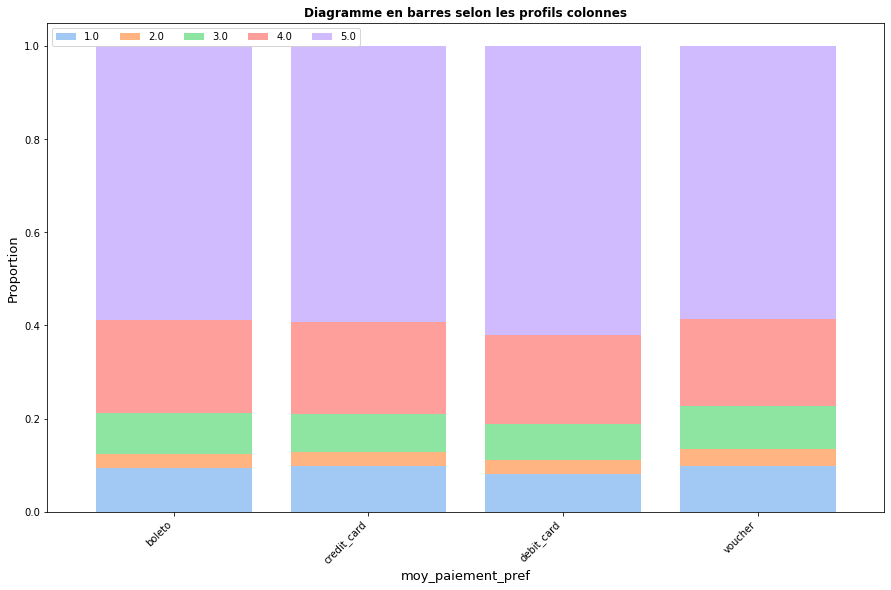

Chaque effectif >= 5 => Test du Chi2 applicable
----------------------------------------------------------
Chi2: 24.61325301151639
Degrees of freedom: 12
----------------------------------------------------------
pvalue: 0.016765695623414074 < 0.05 => var dépendantes


In [106]:
chi2_test(df_conso, 'moy_paiement_pref', 'review_score')

Le test du Chi2 confirme l'hypothèse d'association entre les variables moy_paiement_pref et review_score. Cependant, la visualisation du diagramme en barres selon les profils colonnes ne nous laisse pas vraiment penser que la satisfaction dépende du moyen de paiement préféré.

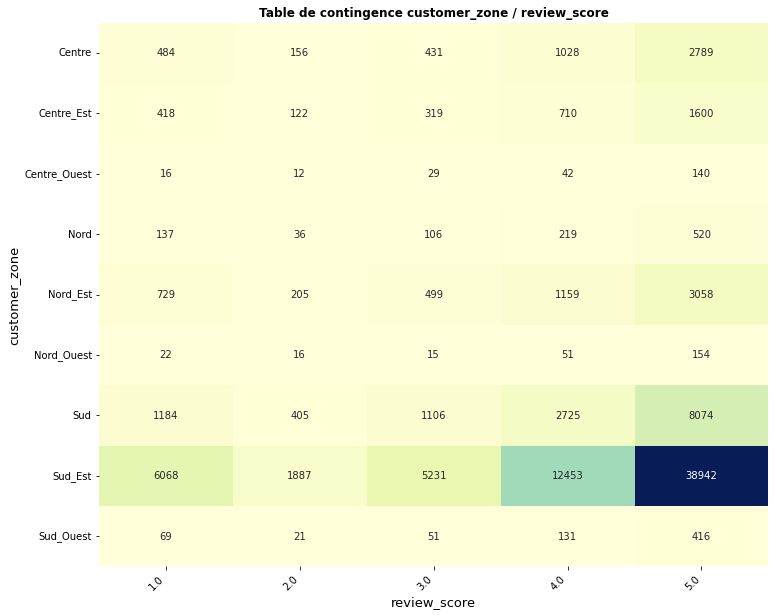

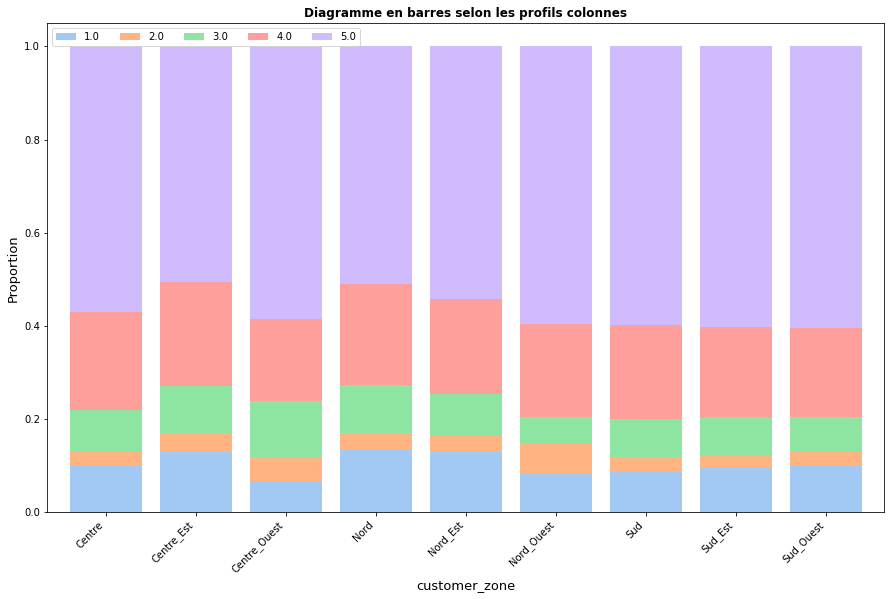

Chaque effectif >= 5 => Test du Chi2 applicable
----------------------------------------------------------
Chi2: 317.52872323834214
Degrees of freedom: 32
----------------------------------------------------------
pvalue: 9.707356201106015e-49 < 0.05 => var dépendantes


In [107]:
chi2_test(df_conso, 'customer_zone', 'review_score')

Le test du Chi2 confirme l'hypothèse d'association entre les variables customer_zone et review_score. Les clients du centre est, nord et nord est semblent plus mécontents que les clients du sud et nord ouest par exemple.

## Consolidation des données (par customer_unique_id) <a class="anchor" id="tab_cli"></a>

Le customer_unique_id représente l'identifiant client pour toutes les commandes. Nous allons passer par la table intermédiaire sur les commandes pour pouvoir calculer les indicateurs aggrégés suivants par **client** (dont les indicateurs RFM utilisés fréquemment dans les segmentations marketing: **Recency** (jours passés depuis le dernier achat), **Frequency** (nombre total de commandes) et **Monetary** (montant total dépensé)):
- catégorie de produits la plus achetée
- date de la dernière commande (nous calculerons ensuite la différence en jours avec la date du jour pour obtenir la **Recency**)
- mode de paiement préféré
- nombre total de commandes (**Frequency**)
- note moyenne des commandes
- nombre moyen de facilités de paiement
- nombre d'articles moyens par commande
- nombre d'articles achetés
- nombre d'articles différents achetés
- montant total dépensé (**Monetary**)
- montant moyen par commande
- prix moyen du transport
- prix moyen des articles par commande
- prix de l'article le plus cher acheté
- prix de l'article le moins cher acheté
- durée moyenne de livraison en jours
- respect de la date de livraison moyenne en jour (négatif = retard de livraison et positif = avance de livraison)
- nombre de jours moyens pour rédiger un commentaire
- distance moyenne entre le client et le vendeur

In [108]:
df_customers = df_conso.groupby(['customer_unique_id'],
                                as_index=False, dropna=False).agg(
    cat_pref=('cat_pref_en', lambda x: x.mode()[0]),
    big_cat_pref=('Big_Categ_pref', lambda x: x.mode()[0]),
    date_dern_com=('order_purchase_timestamp', 'max'),
    moy_paiement_pref=('moy_paiement_pref', lambda x: x.mode()[0]),
    Frequency=('order_id', 'nunique'),
    note_moy_com=('review_score', 'mean'),
    facil_paiement_max_moy_com=('facil_paiement_max', 'mean'),
    nb_art_moy_com=('nb_art', 'mean'),
    nb_art_tot_ach=('nb_art', 'sum'),
    nb_art_diff_ach=('nb_art_diff', 'sum'),
    Monetary=('prix_tot_art', 'sum'),
    montant_moy_com=('prix_tot_art', 'mean'),
    prix_trans_moy_com=('prix_transport', 'mean'),
    prix_moy_art_com=('prix_tot_art', 'mean'),
    prix_max_art=('prix_art_max', 'max'),
    prix_min_art=('prix_art_min', 'min'),
    jrs_livr_moy_com=('dur_livr_jrs', 'mean'),
    respect_date_livr_moy_com=('diff_estime_livr_jrs', 'mean'),
    jrs_redac_review_moy_com=('redac_com_jrs', 'mean'),
    dist_cli_vend_moy_km=('distance_km', 'mean'))

In [109]:
# Création table avec la Zone la plus récente du client
tab_zone_cli = df_conso.groupby(['customer_unique_id', 'customer_zone'],
                                as_index=False, dropna=False).agg(
    order_purchase_timestamp=('order_purchase_timestamp', 'max')).sort_values(
    by='order_purchase_timestamp', ascending=False)

# Nombre de lignes ayant le même customer_unique_id
print(f"Nb lignes: {tab_zone_cli.duplicated('customer_unique_id').sum()}")

# On converve la zone la plus récente
tab_zone_cli = tab_zone_cli.drop_duplicates('customer_unique_id',
                                            keep='first')

Nb lignes: 23


In [110]:
# Ajout de la zone la plus récente du client
df_customers = pd.merge(left=df_customers, right=tab_zone_cli,
                        how='left', on='customer_unique_id')

In [111]:
# Vérification que la table contient bien une ligne par client
df_customers.shape[0] == df_conso['customer_unique_id'].nunique()

True

In [112]:
# Date de commande la plus récente:
df_customers['date_dern_com'].max()

Timestamp('2018-08-29 15:00:37')

Nous allons calculer la "Recency" en partant du principe que nous sommes le 31/08/2018, 23h59.

In [113]:
# Calcul de la "Recency"
now = dt.datetime(year=2018, month=8, day=31, hour=23, minute=59, second=0)
now

datetime.datetime(2018, 8, 31, 23, 59)

In [114]:
df_customers['Recency'] = (now - df_customers[
    'date_dern_com']).dt.days

In [115]:
df_customers.head()

,customer_unique_id,cat_pref,big_cat_pref,date_dern_com,moy_paiement_pref,Frequency,note_moy_com,facil_paiement_max_moy_com,nb_art_moy_com,nb_art_tot_ach,nb_art_diff_ach,Monetary,montant_moy_com,prix_trans_moy_com,prix_moy_art_com,prix_max_art,prix_min_art,jrs_livr_moy_com,respect_date_livr_moy_com,jrs_redac_review_moy_com,dist_cli_vend_moy_km,customer_zone,order_purchase_timestamp,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table,house/decoration/furnitures,2018-05-10 10:56:27,credit_card,1,5.0,8.0,1.0,1.0,1.0,129.90,129.90,12.00,129.90,129.90,129.90,6.0,4.0,4.0,110.459074,Sud_Est,2018-05-10 10:56:27,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty,hygiene/beauty,2018-05-07 11:11:27,credit_card,1,4.0,1.0,1.0,1.0,1.0,18.90,18.90,8.29,18.90,18.90,18.90,3.0,4.0,0.0,22.219469,Sud_Est,2018-05-07 11:11:27,116
2,0000f46a3911fa3c0805444483337064,stationery,house/decoration/furnitures,2017-03-10 21:05:03,credit_card,1,3.0,8.0,1.0,1.0,1.0,69.00,69.00,17.22,69.00,69.00,69.00,25.0,1.0,1.0,516.692345,Sud,2017-03-10 21:05:03,539
3,0000f6ccb0745a6a4b88665a16c9f078,telephony,electronics,2017-10-12 20:29:41,credit_card,1,4.0,4.0,1.0,1.0,1.0,25.99,25.99,17.63,25.99,25.99,25.99,20.0,11.0,1.0,2479.683397,Nord,2017-10-12 20:29:41,323
4,0004aac84e0df4da2b147fca70cf8255,telephony,electronics,2017-11-14 19:45:42,credit_card,1,5.0,6.0,1.0,1.0,1.0,180.00,180.00,16.89,180.00,180.00,180.00,13.0,7.0,4.0,154.421184,Sud_Est,2017-11-14 19:45:42,290


In [116]:
# Taux de remplissage des colonnes
NaN_nb_percent(df_customers)

,Tx de remplissage,Nb NaN
customer_unique_id,100.0,0
cat_pref,100.0,0
order_purchase_timestamp,100.0,0
customer_zone,100.0,0
dist_cli_vend_moy_km,100.0,0
jrs_redac_review_moy_com,100.0,0
respect_date_livr_moy_com,100.0,0
jrs_livr_moy_com,100.0,0
prix_min_art,100.0,0
prix_max_art,100.0,0


### Analyse des indicateurs RFM

In [117]:
describe_variables(df_customers)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,customer_unique_id,object,0000366f3b9a7992bf8c76cfdf3221e2,91004,91004,100.0,91004,100.0,0,0.0,,,,,,,,,,
1,cat_pref,object,bed_bath_table,91004,71,0.08,91004,100.0,0,0.0,,,,,,,,,,
2,big_cat_pref,object,house/decoration/furnitures,91004,14,0.02,91004,100.0,0,0.0,,,,,,,,,,
3,date_dern_com,datetime64[ns],2018-05-10 10:56:27,91004,90776,99.75,91004,100.0,0,0.0,,,,,,,,,,
4,moy_paiement_pref,object,credit_card,91004,4,0.0,91004,100.0,0,0.0,,,,,,,,,,
5,Frequency,int64,1,91004,9,0.01,91004,100.0,0,0.0,1.03,1.0,10.7,284.56,0.04,0.21,1,1.0,1.0,14
6,note_moy_com,float64,5.0,91004,26,0.03,91004,100.0,0,0.0,4.15,5.0,-1.48,0.97,1.64,1.28,1.0,4.0,5.0,5.0
7,facil_paiement_max_moy_com,float64,8.0,91004,68,0.07,91004,100.0,0,0.0,2.92,2.0,1.61,2.43,7.25,2.69,0.0,1.0,4.0,24.0
8,nb_art_moy_com,float64,1.0,91004,40,0.04,91004,100.0,0,0.0,1.14,1.0,7.34,107.86,0.27,0.52,1.0,1.0,1.0,21.0
9,nb_art_tot_ach,float64,1.0,91004,19,0.02,91004,100.0,0,0.0,1.18,1.0,7.3,108.35,0.38,0.62,1.0,1.0,1.0,24.0


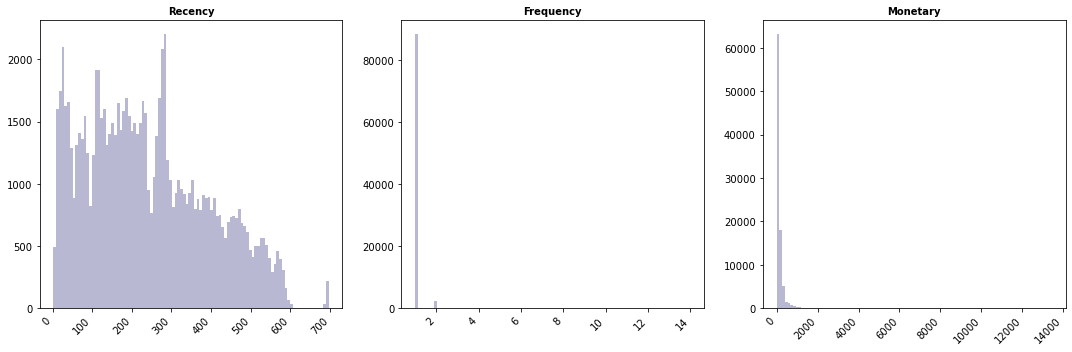

In [118]:
col_quanti = ['Recency', 'Frequency', 'Monetary']

fig = plt.figure(figsize=(15, 5))
univ_plots_hist(df_customers, col_quanti, 1, 3, 100)

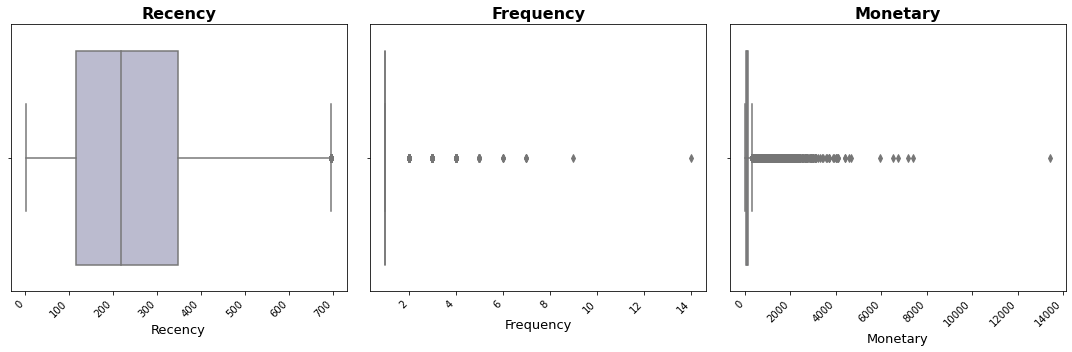

In [119]:
fig = plt.figure(figsize=(15, 5))
univariate_plots_box(df_customers, col_quanti, 1, 3)

- Le nombre de jours passés depuis le dernier achat se situe entre 2 et près de 700 jours avec une moyenne de 239 jours et une médiane de 219 jours
- Les clients effectuent 1 commande en moyenne avec un maximum de 14 commandes
- Les clients ont dépensé en moyenne 141 Réals

In [120]:
# Liste des clients ayant passé plusieurs commandes
cli_multi_order = df_customers[df_customers['Frequency'] > 1]
cli_multi_order = cli_multi_order['customer_unique_id'].unique().tolist()

# % de clients ayant passé plusieurs commandes
nb_cli_multi = len(cli_multi_order)
nb_cli = df_customers['customer_unique_id'].nunique()
nb_cli_multi_percent = nb_cli_multi / nb_cli * 100
print(f"% clients avec plusieurs commandes {round(nb_cli_multi_percent,2)}")

% clients avec plusieurs commandes 2.95


In [121]:
nb_cli_multi_percent

2.949320908971034

On retombe bien sur les 3% de clients indiqués dans l'énoncé.

In [122]:
# Export des données
df_customers.to_csv('data/df_customers.csv')
df_conso.to_csv('data/df_conso.csv')